In [85]:
import pandas as pd
import numpy as np
import re 
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
imdb = pd.read_csv("IMDB Dataset.csv")

In [6]:
twitter = pd.read_csv("twitter.csv", encoding="ISO-8859-1")

In [8]:
twitter.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
imbd.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
twitter.columns = ["sentiment", "id", "date", "query", "user", "review"]

In [11]:
twitter.head()

,sentiment,id,date,query,user,review
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [13]:
twitter = twitter[["review", "sentiment"]]

In [14]:
twitter.head()

,review,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [17]:
sentiment_map = {"negative": 0, "positive": 4}
imdb["sentiment"] = imdb["sentiment"].map(sentiment_map)

In [18]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,4
1,A wonderful little production. <br /><br />The...,4
2,I thought this was a wonderful way to spend ti...,4
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",4


In [19]:
combined = pd.concat([twitter, imdb], ignore_index=True)

In [20]:
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
combined.to_csv("combined_sentiment.csv", index=False)

In [22]:
combined.shape

(1649999, 2)

In [23]:
df = combined

In [42]:
def preprocess_text(text):
    """
    Cleans a single piece of text by performing all preprocessing steps.
    """
    # Make text lowercase
    text = text.lower()
    
    # Remove noise (URLs, mentions, hashtags)
    text = re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', text, flags=re.MULTILINE)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split text into a list of words (tokens)
    tokens = word_tokenize(text)
    
    # Remove common English words (stop words)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Reduce words to their base form (lemmatization)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join the clean words back into a single string
    return " ".join(lemmatized_tokens)


In [44]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
df['processed_review'] = df['review'].apply(preprocess_text)
print("Preprocessing complete!")


Preprocessing complete!


In [48]:
X = df['processed_review']
y = df['sentiment']


In [55]:
vectorizer = TfidfVectorizer(max_features= 30000)


In [56]:
X_vectorized = vectorizer.fit_transform(X)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42
)

In [59]:
X_train.shape

(1319999, 30000)

In [60]:
X_test.shape

(330000, 30000)

In [78]:
lr_model = LogisticRegression(max_iter=10000)
nb_model = MultinomialNB()
svm_model = LinearSVC(max_iter=10000, dual=False) 

In [79]:
estimators = [
    ('logistic_regression', lr_model),
    ('naive_bayes', nb_model),
    ('support_vector_machine', svm_model)
]


In [80]:
hybrid_model = VotingClassifier(estimators=estimators, voting='hard')

In [81]:
hybrid_model.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(max_iter=10000)),
                             ('naive_bayes', MultinomialNB()),
                             ('support_vector_machine',
                              LinearSVC(dual=False, max_iter=10000))])

In [69]:
hybrid_predictions = hybrid_model.predict(X_test)
print("\n--- Hybrid Model ---")
print(f"Accuracy: {accuracy_score(y_test, hybrid_predictions):.4f}")
print(classification_report(y_test, hybrid_predictions))


--- Hybrid Model ---
Accuracy: 0.7805
              precision    recall  f1-score   support

           0       0.79      0.76      0.78    165072
           4       0.77      0.80      0.78    164928

    accuracy                           0.78    330000
   macro avg       0.78      0.78      0.78    330000
weighted avg       0.78      0.78      0.78    330000



In [76]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [77]:
lr_predictions = lr_model.predict(X_test)
print("\n--- Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(classification_report(y_test, lr_predictions))


--- Logistic Regression ---
Accuracy: 0.7807
              precision    recall  f1-score   support

           0       0.79      0.76      0.78    165072
           4       0.77      0.80      0.78    164928

    accuracy                           0.78    330000
   macro avg       0.78      0.78      0.78    330000
weighted avg       0.78      0.78      0.78    330000



In [72]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes model trained.")

Naive Bayes model trained.


In [73]:
nb_predictions = nb_model.predict(X_test)
print("\n--- Naive Bayes ---")
print(f"Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(classification_report(y_test, nb_predictions))


--- Naive Bayes ---
Accuracy: 0.7642
              precision    recall  f1-score   support

           0       0.76      0.76      0.76    165072
           4       0.76      0.76      0.76    164928

    accuracy                           0.76    330000
   macro avg       0.76      0.76      0.76    330000
weighted avg       0.76      0.76      0.76    330000



In [74]:
svm_model = LinearSVC(max_iter=1000, dual=False) 
svm_model.fit(X_train,y_train)

LinearSVC(dual=False)

In [75]:
svm_predict = svm_model.predict(X_test)
print("\n--- SVM ---")
print(f"Accuracy: {accuracy_score(y_test, svm_predict):.4f}")
print(classification_report(y_test, svm_predict))


--- SVM ---
Accuracy: 0.7795
              precision    recall  f1-score   support

           0       0.79      0.76      0.78    165072
           4       0.77      0.80      0.78    164928

    accuracy                           0.78    330000
   macro avg       0.78      0.78      0.78    330000
weighted avg       0.78      0.78      0.78    330000



In [83]:
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)


best_model = hybrid_model 
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Vectorizer and model have been saved to files:")
print("-> tfidf_vectorizer.pkl")
print("-> sentiment_model.pkl")

Vectorizer and model have been saved to files:
-> tfidf_vectorizer.pkl
-> sentiment_model.pkl


In [84]:
# Assuming your sentiment column is named 'sentiment'
sentiment_counts = df['sentiment'].value_counts()

print("Sentiment Distribution:")
print(sentiment_counts)

Sentiment Distribution:
sentiment
4    825000
0    824999
Name: count, dtype: int64


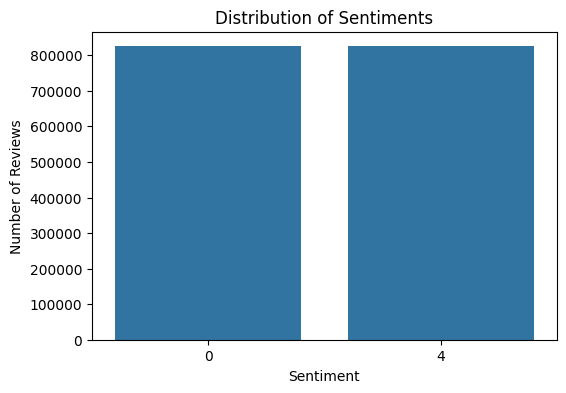

In [87]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()